In [3]:
# necessary packages
import pandas as pd
import multiprocessing as mp
import time
import pickle
import networkx
import matplotlib.pyplot as plt

## Creating a DataFrame from the Dataset

In [4]:
def load_data(filename):
    df = pd.read_csv(filename)
    return df
df = load_data('data.csv')

## Creating Address Clusters

In [5]:
def get_input_addrs(tx):
    return set(df[df['tx_hash'] == tx]['inputs_addresses'])

def get_prelim_clusters(df):
    start = time.time()
    with mp.Pool() as pool:
        prelim = pool.map(get_input_addrs, set(df['tx_hash']))
        pool.close()
        pool.join()
    end = time.time()
    print(f'Creating the prelim clusters took {round((end - start) / 60, 2)} min.')
    return prelim

def construct_clusters(prelim):
    def pairs(lst):
        i = iter(lst)
        first = prev = item = next(i)
        for item in i:
            yield prev, item
            prev = item
        yield item, first
        
    graph = networkx.Graph()
    for cluster in prelim:
        for edge in pairs(cluster):
            graph.add_edge(*edge)
    clusters = list(networkx.connected_components(graph))
    return clusters

def write_clusters(clusters):
    clusters.sort(key=len, reverse=True)
    lookup = {'addrs': [], 'cluster_num': [], 'label': [], 'entity': []}
    for idx, cluster in enumerate(clusters):
        for addr in cluster:
            lookup['addr'].append(addr)
            lookup['cluster_id'].append(idx + 1)
            lookup['label'].append(None)
            lookup['entity'].append(None)
    pd.DataFrame.from_dict(lookup).to_csv('clusters.csv', index=False)

# prelim = get_prelim_clusters(df)
# clusters = construct_clusters(prelim)
# write_clusters(clusters)

## Labeling the Data

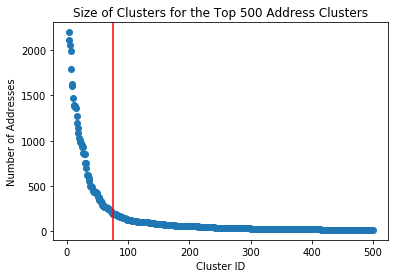

The top 75 clusters (in terms of size) contain 29.62% of the addresses.


In [31]:
clusters = pd.read_csv('clusters.csv')
gb = clusters.groupby('cluster_id', as_index = False).count()
# plt.bar(gb['addrs'][:1000])
plt.scatter(gb['cluster_id'][2:500], gb['addr'][2:500])
plt.axvline(75, color = 'red')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Addresses')
plt.title('Size of Clusters for the Top 500 Address Clusters')
plt.show()
percent = round(sum(gb['addr'][:75])/sum(gb['addr']) * 100, 2)
print(f'The top 75 clusters (in terms of size) contain {percent}% of the addresses.')

In [32]:
def add_label(addr, label, entity):
#   this utility allows us to label all addrs in a cluster 
#   by providing a single address
    cluster_id = clusters[clusters['addr'] == addr]['cluster_id'].values[0]
    clusters.loc[clusters['cluster_id'] == cluster_id, 
                 ['label', 'entity']] = label, entity

    return clusters
    
add_label('LPRqS1Y7nET9p9ETBD1ndBSkxWSuARMRUZ', 'GAMBLING', 'FortuneJack')
add_label('LhZBnhHjGVssKR87f9ZXv1D4pUAEU4q4B4', 'EXCHANGE', 'Binance 3')
add_label('LcNw4i7txvZSWpMBSKSYJMgzvKTBFjQFd9', 'EXCHANGE', 'Indodax')
# LQH5UapBSPDHwSBRwbKgo6gFm79QxiaELR 4
add_label('LXMk3TGeuPKHjHUU37fgPBYgtu5ekLZzcz', 'EXCHANGE', 'YoBit')
add_label('LRTW7dZmtasUUV53PTAhYS8YnPm2ugwh4b', 'EXCHANGE', 'Cryptonator') # wallet
add_label('M8Cpu5hzPBzP7T4f7KgeDBSAfY2q6vaXNy', 'MINING', None)
add_label('LScdfiwDfmnnGUZae83UsyZbvHNyAwxepT', 'EXCHANGE', 'Huobi')
add_label('LVNWBJ2UCFwfdu9GKCywo3sSqiWkJpUETu', 'EXCHANGE', 'Uphold')
add_label('MDiSqrndFTsQKvwkVkzUKF73hsX6fWR4eG', 'EXCHANGE', 'CoinPayments') #payment gateway
add_label('MB391cADC4XXjhbUDwYaBg3f4CRBrGTaD4', 'EXCHANGE', 'Payeer')
add_label('LaNjprMCaUbSZY5KnBF8d5AJ6WJrdhfPjP', 'EXCHANGE', 'Bittrex')
add_label('Ld1X2bCRE4pSb7myn4xjdakFAadaRNXF6R', 'EXCHANGE', 'Binance 2')
add_label('LNjgEjtvbVpBPyqxeKv77XmwLatH5atTkP', 'EXCHANGE', 'ZB')
# MSK4Kwu1uEeW7aqQsXChy74g6GPAgmya9d 15
add_label('LbMXR4dHkFXupgWAZY377d7vVvpVVjALoP', 'EXCHANGE', 'Poloniex')
# LXtj4TFtXtq1vf22ARupUpnDs71rtCtzGU 17
# LY5bvVH1LFm6xrkWLPR9EcYQb67pKeQSTU 18
add_label('LfCjrYQX5mjZanBDQH5K24JE5KokNc3dfJ', 'EXCHANGE', 'Binance 1')
add_label('MGAgCuuom2bweZwDhGaZfxoBB9KdZTdXZS', 'EXCHANGE', 'Mercado Bitcoin')
# LNGbcvcRsTghhEKoneZtu43mVFQK6tWGaG 21
# MUezwVvsgaeBkcLRDMhzGMBXveL6ufJi3p 22
# LTBApJojYrBmAYcudLd6wmTrKVHwHvraty 23
# LccNHNxewPEgg4bV3h62PjxoESi5DnE1hU 24
# M7y84VgYWuW2fjYSmxJAztnTYqgBxYf4yU 25
# LZPLw8GTzQ6dBdWjv4NTAaJq8sGueRDtdV 26
# MULbzhoqjp1MKR1ip9aorWbnAWR2BaKspE 27
# MEYUes6EvBruLx43Q2GJ6QDYwzReSUYhR9 28
# LdsoyHfbpuTac3fYJgWabqH19XSCtVQzkX 29
# MJmb8hvqz4BwHwVZ8x2K7u2yFSkq8r3NAH 30
add_label('MLQETKSg6vMLgQyB9Z1ZJs4iXETFLAVKef', 'EXCHANGE', 'Bitstamp')
# MTuUvn32kA9j5EWS5GySfGhW2akvPwqGTT 32
# LTXf5oP4pnkN9XbCCqP3nUUAqtYepeyhMc 33
add_label('LUhyPyU4fm3y9EHh1fA7qbxdF74FtoVvRN', 'EXCHANGE', 'EXMO')
add_label('LcuWai9rB86FNdUNNCKgvnuxXysSGUpZRi', 'EXCHANGE', 'CoinExchange')
add_label('MA68NqAVaQaBuroqmFKcqZ75grKPyXWHH2', 'EXCHANGE', 'Bitso')
# MUHVNxR7kdeASkvM5rugPVbrCgegpQhM31 37
# LdyuhX4NpxqCgNAx1YFLJ3cpU8emHUJnhi 38
# LX9MLdo3824uwiN9cExfPZ79kgEp3QDoru 39
add_label('LU5nzkDb1Jwjwd1sMXp6a1Y4MH8GEGKXTk', 'EXCHANGE', 'KuCoin')
add_label('LKYsLLZarBuqDJ3LzHGjjKgEjcEjxthXCG', 'EXCHANGE', 'ZB')
# LZZmVMpMaCzDY82Fj3MFkeyDM5Fi1uvjAu 42
# LLPi2a6Uv2HjQfGhu7Bc44ftHASok1JpKF 43
# LbAsg6m9UTAShzHgwJdPpa2HWLoUwBn8V2 44
add_label('LcYNhVMY8c31bt7Zz8AFsPm8Eo6CyAz4RP', 'EXCHANGE', 'Bitfinex')
# LXfeBhzrtvU8zbuCfLuPbyoQWiXGAbA68c 46
# MHMdce59hNS2o8s6KJsZ6TxViKonHRa6X5 47
add_label('LN1aHvEGrcDuXqMfDq6NKjyKwviBCCZrpa', 'EXCHANGE', 'Gate.io')
# MTezYjBpjDYuVPnbPd75JRcGiyrG4PEhmv 49
# LMUEDudHhAQrXq654QKKjWfqkh1iwJP2Va 50
# LfMK3M4XmWrTi1wUwn75Hcsx3GqhgYUhNx 51
add_label('LeiWMjMtr1Lzs2m6feUyQ7ZB96L26yLnAh', 'EXCHANGE', 'BX.in.th')
# LeLM9oMdpvzfyYPMjJ1odgGENGMshj7GCH 53
# ME9yyTPAJij9vs6apWXZfgnH8Qq7ofmmUu 54
# LhMEP7yTbKGgMMxHyLR7Q8N1WFohuLry49 55
# Lg1SKpdLvcfniomWi11yVmpTv6ShtUgRXL 56
add_label('M9G79smVeLmZwRtAK1mEL38f7uswZnk4AR', 'GAMBLING', 'YOLOdice')
add_label('LcKH7JVVtWSvc9iz1CaNGhU5yqac8YY4JB', 'GAMBLING', 'MbitCasino / BitcoinCasinoUS / BitStarz')
add_label('MRoqikAv8pvLCNL1tXc6roAAQ8sWQcnEWE', 'GAMBLING', 'DuckDice')
# MSq5vW7N92P5co1uFsFc3gThm1gnH1C6tx 60
# LhTwueGFCHsE1r3WNxjajb19MESMEX6PK5 61
# LQ9d7i55hMcvGaY9VpDBZus7qPAyQqt9dj 62
# MSNdDABnbNtjU8CdBu5LSUoUPtifvTHwee 63
add_label('MGbcJKWj4bV1Pzdcq6miPpaLrnCNhKh8uM', 'EXCHANGE', 'WebMoney') # payment settlement
add_label('MTVj9MhWjKnhkwTLscFps2ynf4wZTKprjs', 'EXCHANGE', 'BitBay')
# LNEY4eJEK5hDDaj5se3kv14BzTovH5DZ5D 66
# MMUxuMEM5kMJeozR17tZbct7PfrGNQME2n 67
# LVu8e5vDPKuTyvK4Ni1DbBMCjgd82qv4Er 68
# M8NMVs7Y3o9E3sZ6fE43F67BkeVZ4JM4db 69
# LXqknqbt97BvTUU2a2An4sn9m4Gy3uywbP 70
# LiLDhw1pr1v28KELs7Q5bFmAkBUFmwfhwG 71
# MFQ5wBXJ24mqpLJhucqVbZuBZpupqAu7Dc 72
# LUEZJfxZamtYVgvXNBrcctmAXh9yexmgKX 73
# MGaDkGCfzv4xyu83ob4U4CaQdSJdhtUr8f 74
# LeuTvsCA5xApGGRQas1J9dfx6nz9mprJBC 75
# LbrhRtzRp2EF4ojNPfTCZakDCzRDSHvgM3 76
# Lbk4MGRrtY39jdyADnaG3vBpbQciEHb8KR 77
# LfRmr68irVR6Q6W2payM92PvnBH9482jW6 78
# MTR7nqGfzbreiGGXxibvY7oGFPWXfWLRZm 79
add_label('LTCPodtg91HsKf5xB1MQ5L13CkcSfd2rCV', 'MINING', 'LitecoinPool.org')
# Lfa7A4ktYMJ99D61uvVHnKA6VWvDBsorcC 81
# LhNTqca9hin1Rpepk8mo1WJ9gH1DaNMxzS 82
# LT3nQwxzBvtruSjB3C1R5UTfGomJd6A2RL 83
add_label('LdQC7mCoawyN9MDmDjkUKYpDxivAbtFsuk', 'EXCHANGE', 'HitBTC')
# M8CDFfJ5ZZbWT1SVnXDHxKHwPumdzYPZ44 85
add_label('LP5DmJPfLbNs3uzZWaKyQFkTNrCR7j4Chu', 'EXCHANGE', 'Kraken')
# LcM9HBAZ4BYUYnGXtWwhJE4Y6AFDge6Ska 87
# MMdhYCT3ocnVyLSHBQNSj9RWwtMUsgAeW8 88
# MLhYSAXCwBXPup8a62xFWQZmWjNuYcro4y 89
add_label('MLSj88LppdnTXPWBN1MbY399UCCXCKvY4w', 'EXCHANGE', 'Alpha Change')
# MNK39SsBiq9PWjiY1ETpNGS7va5M5vWyat 91
# MJBsNuBYnCfsrNE9pVoKeU3DspQwrvs3xw 92
add_label('M9SfmJeymTxVBrauUJsNEpHogY8jqPGRwR', 'EXCHANGE', 'CryptoBridge')
add_label('M9YaCyNpqTbNZ3tRwwTKCoat58ux9kzZ8m', 'GAMBLING', '1xBit')
add_label('MLTkbKnob3V6DtZFQ3bbJZtzteWUcdRz9Z', 'EXCHANGE', 'TradeSatoshi')
# MHrsQzDa5gDZwDZescQS2scb88F4nBgFxV 96
add_label('MHd3ridcTrtBbdXBtPssCuqzDT99mJKmZf', 'EXCHANGE', 'Livecoin')
add_label('MBg2bhbEN5HXPcq5VghThX3iJB2djfVmnk', 'EXCHANGE', 'QuadrigaCX')
add_label('Lec94JCcKNUvpxAjhgv1YXVdgB5ZDkmP3N', 'GAMBLING', 'LuckyGames')
# LP1NaZDCBZY6CXpRJxG4FiJMffsrhoSHLY 100

# ---------------------------------------------------------------------
add_label('LdUEVLExGMpHcya77zxt5dfyoKCtXxWhGm', 'MINING', 'F2Pool')
add_label('LZo1qx6S5JEVh43KahTFBdvnkVFeQCz9Ze', 'MINING', 'Poolin.com')
add_label('LLgJTbzZMsRTCUF1NtvvL9SR1a4pVieW89', 'MINING', 'AntPool')
add_label('LhkFjuGkVcdriLU2HWnph1tSLd9Fk7deCn', 'MINING', 'Prohashing')
add_label('LUazv9uUA4rmdmm54HjzTH72vRahHaKJSc', 'MINING', 'Mining Dutch')
add_label('LaQASpgm6oWTJ4sYDF5xJHdiZYkMP7uSW1', 'MINING', 'MiningPoolHub')
add_label('LLMRAtr3qBje2ySEa3CnZ55LA4TQMWnRY3', 'MINING', 'LTC.top')
add_label('LfmssDyX6iZvbVqHv6t9P6JWXia2JG7mdb', 'MINING', 'ViaBTC')
add_label('LLpN93cN6oNhL6PA615tiwr2CXauiPGGr1', 'MINING', None)
add_label('LaKd2Pa578Zg51xLb4UiXabeZe3q24XbR6', 'MINING', None)
add_label('LR5FzTHXfa4aGtozDJN5QmifNbVFxAwdui', 'MINING', None)
add_label('LZ43jcFdxNVpJWJ6o3neYEsnqEGxQTsP9M', 'MINING', None)

# ---------------------------------------------------------------------
add_label('LQqCmx6oEuHHTLF82wWAaVpfmHNZfi2SvW', 'GAMBLING', '999Dice')
add_label('LKeCCvMavn8bawyeyEhLkwjBM6SJZHGh69', 'GAMBLING', '999Dice')

add_label('MMfrXgS3j1mwD87BPZtkGEhnHRDXZN2pHh', 'EXCHANGE', 'Coinone')
add_label('LddFLSodo495K4C8AbDbt3kLQ2E19DDyzt', 'EXCHANGE', 'Coinbase')
# clusters.to_csv('clusters.csv', index=False)


percent = (1 - sum(clusters['label'].isna()) / len(clusters)) * 100
print(f'Labeled {round(percent, 2)}% of the data.')

Labeled 18.49% of the data.


In [33]:
clusters = clusters.fillna('OTHER')
sum(clusters['label'].isna())

0

In [8]:
def cluster_by_id(cluster_id):
    return clusters[clusters['cluster_id'] == cluster_id]
    
cluster_by_id(100)

,addr,cluster_id,label,entity
70319,LP1NaZDCBZY6CXpRJxG4FiJMffsrhoSHLY,100,NaN,NaN
70320,ME4TbvxRF8fzHQpDQjcvniEi3diL2xB4bv,100,NaN,NaN
70321,MEpNmqapuJfe7iVkQPaTqhWBRXkv67mWKN,100,NaN,NaN
70322,MDsF4Tt3RVpPmJbYYMPK8kBiqcARog2CtP,100,NaN,NaN
70323,LhfZ1vin2yfyCBSbbghyRPZgpanR8wCG8S,100,NaN,NaN
70324,MJVvzZ6Hd12VFsbn41gNA4D6c55LbWpEaQ,100,NaN,NaN
70325,LSHRxoCSjrrdfGBNZqQTJXnXYCm4MQbmfV,100,NaN,NaN
70326,MHzWCU5D98Hcm6ijRaA8atz9u3UpLsHbZF,100,NaN,NaN
70327,M9DDeAfA92Anzuh7PvanE7NAR2hBPQ7yQo,100,NaN,NaN
70328,LWnfjxcs2em3rvX18i7TzhhXz8rAoA4bqW,100,NaN,NaN


In [9]:
def cluster_by_addr(addr):
    cluster_id = clusters[clusters['addr'] == addr]['cluster_id'].values[0]
    return cluster_by_id(cluster_id)

cluster_by_addr('LP1NaZDCBZY6CXpRJxG4FiJMffsrhoSHLY')

,addr,cluster_id,label,entity
70319,LP1NaZDCBZY6CXpRJxG4FiJMffsrhoSHLY,100,NaN,NaN
70320,ME4TbvxRF8fzHQpDQjcvniEi3diL2xB4bv,100,NaN,NaN
70321,MEpNmqapuJfe7iVkQPaTqhWBRXkv67mWKN,100,NaN,NaN
70322,MDsF4Tt3RVpPmJbYYMPK8kBiqcARog2CtP,100,NaN,NaN
70323,LhfZ1vin2yfyCBSbbghyRPZgpanR8wCG8S,100,NaN,NaN
70324,MJVvzZ6Hd12VFsbn41gNA4D6c55LbWpEaQ,100,NaN,NaN
70325,LSHRxoCSjrrdfGBNZqQTJXnXYCm4MQbmfV,100,NaN,NaN
70326,MHzWCU5D98Hcm6ijRaA8atz9u3UpLsHbZF,100,NaN,NaN
70327,M9DDeAfA92Anzuh7PvanE7NAR2hBPQ7yQo,100,NaN,NaN
70328,LWnfjxcs2em3rvX18i7TzhhXz8rAoA4bqW,100,NaN,NaN


In [10]:
num_clusters_labeled = sum(clusters.groupby('cluster_id').count()['label'] > 0)
num_clusters_labeled

56

Will's Stuff

In [11]:
def feature_const_in(x):
    d = {}
    d['total_fee_in'] = x['fee'].sum()
    d['avg_feerate_in'] = (x['fee']/x['tx_size']).mean()
    d['total_tx_inputs_val'] = x['inputs_value'].sum()
    d['total_tx_input_count'] = x['input_count'].sum()
    d['total_input_tx'] = x['inputs_addresses'].count()
    d['total_is_coinbase_in'] = x['is_coinbase'].sum().astype(int)
    return pd.Series(d, index=['total_fee_in', 
                               'avg_feerate_in', 
                               'total_tx_inputs_val', 
                               'total_tx_input_count', 
                               'total_input_tx', 
                               'total_is_coinbase_in'])

inputs_table = df.groupby('inputs_addresses').apply(feature_const_in)
inputs_table = inputs_table.reset_index()
inputs_table

,inputs_addresses,total_fee_in,avg_feerate_in,total_tx_inputs_val,total_tx_input_count,total_input_tx,total_is_coinbase_in
0,LKDxQX96YCUTeQ2pTdnAddmbsCDdM9SkxV,163600.0,100.368098,9.864800e+07,10.0,2.0,0.0
1,LKDxkfMcNa5cEPo16dUwpRS5rfWDLZcsCu,1753344.0,100.524252,1.655764e+08,99.0,9.0,0.0
2,LKDyWZYWL6YQdRUG4Eh1EzEpH2kYt16qdH,74800.0,100.000000,2.670078e+08,4.0,2.0,0.0
3,LKDytn3nHLM4BArNha8z2A5274CLH1oKbe,15555600.0,100.347056,1.925500e+06,1050.0,2.0,0.0
4,LKDz1qP2gRt5oX79rManZuqMqJ5vQ3Dkyy,507200.0,100.185158,1.092788e+10,28.0,12.0,0.0
5,LKE2QeVhQizaA5oWSY7k3oXs1ss6WyFpwM,229600.0,87.366819,6.843540e+08,16.0,2.0,0.0
6,LKE2Ro5KGrLse5gRMGHQXwNKXYZVzN5ujj,3210800.0,206.392925,1.550000e+10,82.0,11.0,0.0
7,LKE3nZNFrY4NgKpYDqGC4yP9WWSiDPKUhp,135600.0,301.333333,2.966517e+08,2.0,2.0,0.0
8,LKE5PEysL7ioGgu1nHMzDYPZZdPZDRcnmG,45200.0,100.000000,4.375218e+08,2.0,2.0,0.0
9,LKE5fRDWKazv2toR1QJd7shx595ejLWQKq,2163600.0,96.918115,1.629716e+06,148.0,2.0,0.0


In [12]:
def feature_const_out(x):
    d = {}
    d['total_fee_out'] = x['fee'].sum()
    d['avg_feerate_out'] = (x['fee']/x['tx_size']).mean()
    d['total_tx_outputs_val'] = x['outputs_value'].sum()
    d['total_tx_output_count'] = x['output_count'].sum()
    d['total_output_tx'] = x['outputs_addresses'].count()
    d['total_is_coinbase_out'] = x['is_coinbase'].sum().astype(int)
    return pd.Series(d, index=['total_fee_out', 
                               'avg_feerate_out', 
                               'total_tx_outputs_val', 
                               'total_tx_output_count', 
                               'total_output_tx', 
                               'total_is_coinbase_out'])

outputs_table = df.groupby('outputs_addresses').apply(feature_const_out)
outputs_table = outputs_table.reset_index()
outputs_table

,outputs_addresses,total_fee_out,avg_feerate_out,total_tx_outputs_val,total_tx_output_count,total_output_tx,total_is_coinbase_out
0,LKDxQX96YCUTeQ2pTdnAddmbsCDdM9SkxV,16800.0,67.469880,4.932400e+07,2.0,1.0,0.0
1,LKDyWZYWL6YQdRUG4Eh1EzEpH2kYt16qdH,250800.0,160.460653,4.005117e+08,6.0,3.0,0.0
2,LKDz1qP2gRt5oX79rManZuqMqJ5vQ3Dkyy,511800.0,94.301705,7.824379e+09,67.0,9.0,0.0
3,LKDznQa25iNbXXt1z7otAcEWE53HBYq8Ac,610.0,3.193717,1.088148e+07,1.0,1.0,0.0
4,LKE2Ro5KGrLse5gRMGHQXwNKXYZVzN5ujj,39400.0,83.822222,2.900000e+09,4.0,2.0,0.0
5,LKE2y9jL9V8AtgCFPCsgXuMhJRDJpb9Pdt,16800.0,67.469880,2.100000e+09,2.0,1.0,0.0
6,LKE3KKfwAK9qvCdiCViL7ih8UBz3sXTRm8,44880.0,120.321716,1.486080e+08,2.0,1.0,0.0
7,LKE3nZNFrY4NgKpYDqGC4yP9WWSiDPKUhp,67800.0,300.000000,1.483258e+08,2.0,1.0,0.0
8,LKE48ivkaeGiK1i8PixG2KnJtYvJ64DnH2,1050000.0,135.013501,1.249698e+08,14.0,7.0,0.0
9,LKE4Vkhf31intxE9TR1Qca8CF6p9LqTaP9,4700.0,20.888889,3.419886e+06,2.0,1.0,0.0


In [13]:
result = pd.merge(left = inputs_table, right = outputs_table,left_on = 'inputs_addresses',right_on = 'outputs_addresses',how = 'left')
result = result.fillna(0)
result

,inputs_addresses,total_fee_in,avg_feerate_in,total_tx_inputs_val,total_tx_input_count,total_input_tx,total_is_coinbase_in,outputs_addresses,total_fee_out,avg_feerate_out,total_tx_outputs_val,total_tx_output_count,total_output_tx,total_is_coinbase_out
0,LKDxQX96YCUTeQ2pTdnAddmbsCDdM9SkxV,163600.0,100.368098,9.864800e+07,10.0,2.0,0.0,LKDxQX96YCUTeQ2pTdnAddmbsCDdM9SkxV,16800.0,67.469880,4.932400e+07,2.0,1.0,0.0
1,LKDxkfMcNa5cEPo16dUwpRS5rfWDLZcsCu,1753344.0,100.524252,1.655764e+08,99.0,9.0,0.0,0,0.0,0.000000,0.000000e+00,0.0,0.0,0.0
2,LKDyWZYWL6YQdRUG4Eh1EzEpH2kYt16qdH,74800.0,100.000000,2.670078e+08,4.0,2.0,0.0,LKDyWZYWL6YQdRUG4Eh1EzEpH2kYt16qdH,250800.0,160.460653,4.005117e+08,6.0,3.0,0.0
3,LKDytn3nHLM4BArNha8z2A5274CLH1oKbe,15555600.0,100.347056,1.925500e+06,1050.0,2.0,0.0,0,0.0,0.000000,0.000000e+00,0.0,0.0,0.0
4,LKDz1qP2gRt5oX79rManZuqMqJ5vQ3Dkyy,507200.0,100.185158,1.092788e+10,28.0,12.0,0.0,LKDz1qP2gRt5oX79rManZuqMqJ5vQ3Dkyy,511800.0,94.301705,7.824379e+09,67.0,9.0,0.0
5,LKE2QeVhQizaA5oWSY7k3oXs1ss6WyFpwM,229600.0,87.366819,6.843540e+08,16.0,2.0,0.0,0,0.0,0.000000,0.000000e+00,0.0,0.0,0.0
6,LKE2Ro5KGrLse5gRMGHQXwNKXYZVzN5ujj,3210800.0,206.392925,1.550000e+10,82.0,11.0,0.0,LKE2Ro5KGrLse5gRMGHQXwNKXYZVzN5ujj,39400.0,83.822222,2.900000e+09,4.0,2.0,0.0
7,LKE3nZNFrY4NgKpYDqGC4yP9WWSiDPKUhp,135600.0,301.333333,2.966517e+08,2.0,2.0,0.0,LKE3nZNFrY4NgKpYDqGC4yP9WWSiDPKUhp,67800.0,300.000000,1.483258e+08,2.0,1.0,0.0
8,LKE5PEysL7ioGgu1nHMzDYPZZdPZDRcnmG,45200.0,100.000000,4.375218e+08,2.0,2.0,0.0,0,0.0,0.000000,0.000000e+00,0.0,0.0,0.0
9,LKE5fRDWKazv2toR1QJd7shx595ejLWQKq,2163600.0,96.918115,1.629716e+06,148.0,2.0,0.0,LKE5fRDWKazv2toR1QJd7shx595ejLWQKq,502960.0,20.000795,8.148580e+05,735.0,1.0,0.0


In [36]:
clusters.shape

(228468, 4)

In [74]:
resMod = pd.merge(left = clusters, right = result, left_on = "addr", right_on = "inputs_addresses",how = "left")
resMod = resMod.dropna()
resMod.head(20)

,addr,cluster_id,label,entity,inputs_addresses,total_fee_in,avg_feerate_in,total_tx_inputs_val,total_tx_input_count,total_input_tx,total_is_coinbase_in,outputs_addresses,total_fee_out,avg_feerate_out,total_tx_outputs_val,total_tx_output_count,total_output_tx,total_is_coinbase_out
0,LPRqS1Y7nET9p9ETBD1ndBSkxWSuARMRUZ,1,GAMBLING,FortuneJack,LPRqS1Y7nET9p9ETBD1ndBSkxWSuARMRUZ,15644400.0,100.347654,1.993722e+06,1056.0,2.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0
1,LXJ5VWG1aj29eMFX5gcmrRvaF7ZPPYAFqA,1,GAMBLING,FortuneJack,LXJ5VWG1aj29eMFX5gcmrRvaF7ZPPYAFqA,15022800.0,100.362091,2.000414e+06,1014.0,2.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0
2,LUfj6N3Qcs8ArpZNCceLQ8dGcwYwkfUonH,1,GAMBLING,FortuneJack,LUfj6N3Qcs8ArpZNCceLQ8dGcwYwkfUonH,15082000.0,100.328619,2.000138e+06,1018.0,2.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0
3,LZbS3KXvkEh6wUaaz6mFhzsmKmgtjVy4gF,1,GAMBLING,FortuneJack,LZbS3KXvkEh6wUaaz6mFhzsmKmgtjVy4gF,16177200.0,100.367291,1.897460e+06,1092.0,2.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0
4,LSyMcvADDU9n7yrP9n8ej759MWK9E2QmZC,1,GAMBLING,FortuneJack,LSyMcvADDU9n7yrP9n8ej759MWK9E2QmZC,11352400.0,100.342950,6.000000e+07,766.0,2.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0
5,LPCoRMPNTESwvtfRZfvZByUWcFtY9PJ5YC,1,GAMBLING,FortuneJack,LPCoRMPNTESwvtfRZfvZByUWcFtY9PJ5YC,14815600.0,100.356296,2.001308e+06,1000.0,2.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0
6,LPubpPc9K4VyQLZa1oBRib51mZ6oP2f4dz,1,GAMBLING,FortuneJack,LPubpPc9K4VyQLZa1oBRib51mZ6oP2f4dz,7878000.0,100.340071,9.626330e+05,532.0,1.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0
7,LRx2ob44ynZqnAZf5CqH4kgZSkbirBHDod,1,GAMBLING,FortuneJack,LRx2ob44ynZqnAZf5CqH4kgZSkbirBHDod,16177200.0,100.367291,1.926438e+06,1092.0,2.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0
8,LdHTPKgkMKHBqy6Ztjoa6xtBkvZvneu68d,1,GAMBLING,FortuneJack,LdHTPKgkMKHBqy6Ztjoa6xtBkvZvneu68d,15082000.0,100.303264,2.001402e+06,1018.0,2.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0
9,LPzmbu66xE6Eaca1NwBc6qkgoL2wGb8YAP,1,GAMBLING,FortuneJack,LPzmbu66xE6Eaca1NwBc6qkgoL2wGb8YAP,14845200.0,100.331166,2.001946e+06,1002.0,2.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0


In [75]:
from sklearn.model_selection import train_test_split

target = 'label'
col_to_drop = [target,"addr","cluster_id","entity","inputs_addresses","outputs_addresses"]
Y = resMod[target]
X = resMod.drop(col_to_drop,axis=1)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)


##TODO: YOUR CODE HERE (Bad Example That Doesn't Work Well)
import time
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:

names = [
    "Nearest Neighbors", 
    "Linear SVM", 
    "RBF SVM", 
#     "Gaussian Process",
    
    "Decision Tree", #.48 wght, .4 score
    "Random Forest",
    "Neural Net", #.48, .45
    "AdaBoost", #.51, .42
    "Naive Bayes", 
    "QDA"
]

classifiers = [
    KNeighborsClassifier(4),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1), # good - .43
#     GaussianProcessClassifier(1.0 * RBF(1.0), n_jobs = -1),
    
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(alpha=1, max_iter=1000), # best - .45
    AdaBoostClassifier(),
    GaussianNB(), # okay - .4
    QuadraticDiscriminantAnalysis()
]

for name, clf in zip(names, classifiers):
    start = time.time()
    clf.fit(X, Y)
    pred = clf.predict(Xtest)
    score = round(clf.score(Xtest, Ytest), 2)
##END:TODO


#calculate accuracy
    from sklearn.metrics import classification_report
    print(name)
    print('-' * 15)
    print(classification_report(Ytest, pred))
    print(f'Score: {score}')
    end = time.time()
    elapsed = round(end - start, 2)
    print(f'Elapsed time: {elapsed}s')
    print('_' * 75)